In [1]:
import spatialdata as sd
import matplotlib.pyplot as plt
import spatialdata_plot
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

data_dir = "/QRISdata/Q1851/Andrew_C/Other_Project/QIMR_Workshop/data/skin_data/"

In [2]:
sdata = sd.read_zarr(f"{data_dir}/Xenium.zarr")

In [3]:
sdata

SpatialData object with:
├── Images
│     ├── 'HE': SpatialImage[cyx] (3, 4633, 14747)
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 37441, 11479), (1, 18720, 5739), (1, 9360, 2869), (1, 4680, 1434), (1, 2340, 717)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 37441, 11479), (1, 18720, 5739), (1, 9360, 2869), (1, 4680, 1434), (1, 2340, 717)
├── Labels
│     ├── 'cell_labels': MultiscaleSpatialImage[yx] (37441, 11479), (18720, 5739), (9360, 2869), (4680, 1434), (2340, 717)
│     └── 'nucleus_labels': MultiscaleSpatialImage[yx] (37441, 11479), (18720, 5739), (9360, 2869), (4680, 1434), (2340, 717)
├── Points
│     └── 'transcripts': DataFrame with shape: (4062390, 10) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (21596, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (21596, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (21596, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (21596, 260)
with 

In [4]:
label_transfer = pd.read_csv(f"{data_dir}../../xenium_label_transfer.csv", index_col=0)
label_transfer.head()

cell_types
aaaanabd-1          Imm_LC
aaagncnp-1  Imm_Fibroblast
aaahjphg-1  Imm_Fibroblast
aaaipkle-1     Melanocytes
aaajabff-1  Imm_Fibroblast

In [5]:
# remove spots in sdata.tables["table"] that have "cell_id" column not in label_transfer.index
sdata.tables["table"] = sdata.tables["table"][sdata.tables["table"].obs["cell_id"].isin(label_transfer.index)]

# add label_transfer to sdata.tables["table"], making sure that the index of label_transfer matches the "cell_id" column of sdata.tables["table"]
sdata.tables["table"].obs = sdata.tables["table"].obs.merge(label_transfer, left_on="cell_id", right_index=True)

In [6]:
sdata.tables["table"].obs["cell_types"]

0                    Imm_LC
1            Imm_Fibroblast
2            Imm_Fibroblast
3               Melanocytes
4            Imm_Fibroblast
                ...        
21591    KC_Differentiating
21592    KC_Differentiating
21593    KC_Differentiating
21594    KC_Differentiating
21595    KC_Differentiating
Name: cell_types, Length: 21593, dtype: object

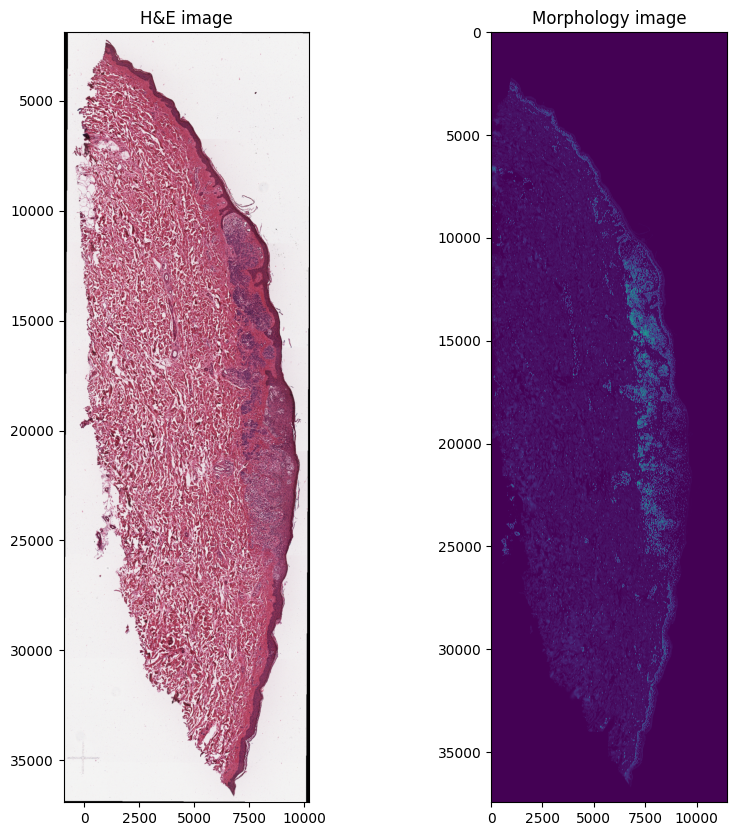

In [7]:
axes = plt.subplots(1, 2, figsize=(10, 10))[1].flatten()
sdata.pl.render_images("HE").pl.show(ax=axes[0], title="H&E image")
sdata.pl.render_images("morphology_focus").pl.show(ax=axes[1], title="Morphology image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


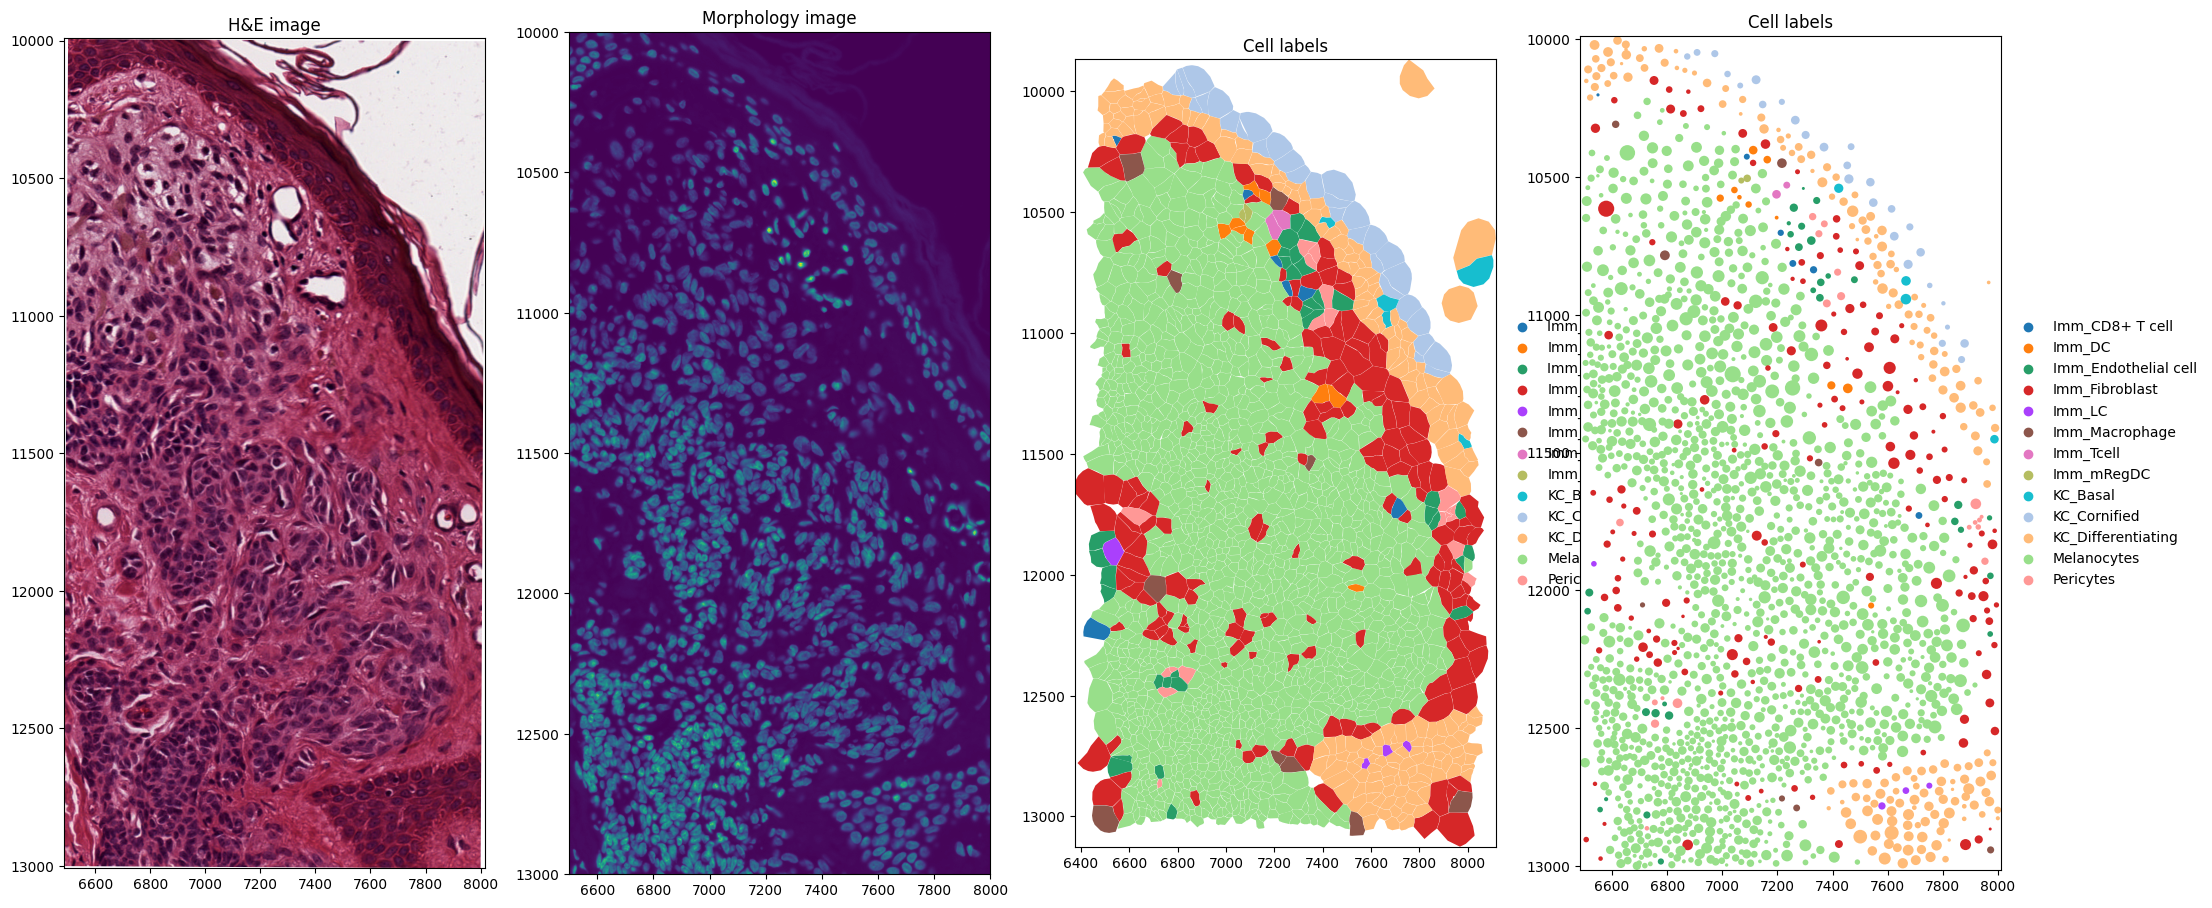

In [10]:
from spatialdata import bounding_box_query

axes = plt.subplots(1, 4, figsize=(25, 20))[1].flatten()
crop0 = lambda x: bounding_box_query(
    x,
    min_coordinate=[6500, 10000],
    max_coordinate=[8000, 13000],
    axes=("x", "y"),
    target_coordinate_system="global",
)
crop0(sdata).pl.render_images("HE").pl.show(ax=axes[0], title="H&E image", coordinate_systems="global")
crop0(sdata).pl.render_images("morphology_focus").pl.show(
    ax=axes[1], title="Morphology image", coordinate_systems="global"
)
sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")
crop0(sdata).pl.render_shapes("cell_boundaries", color="cell_types").pl.show(ax=axes[2], title="Cell labels", coordinate_systems="global")
sdata.tables["table"].obs["region"] = "cell_circles"
sdata.set_table_annotates_spatialelement("table", region="cell_circles")
crop0(sdata).pl.render_shapes("cell_circles", color="cell_types").pl.show(ax=axes[3], title="Cell labels", coordinate_systems="global")

In [11]:
import scanpy as sc

sc.pp.normalize_total(sdata.tables["table"])
sc.pp.log1p(sdata.tables["table"])
sc.pp.highly_variable_genes(sdata.tables["table"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


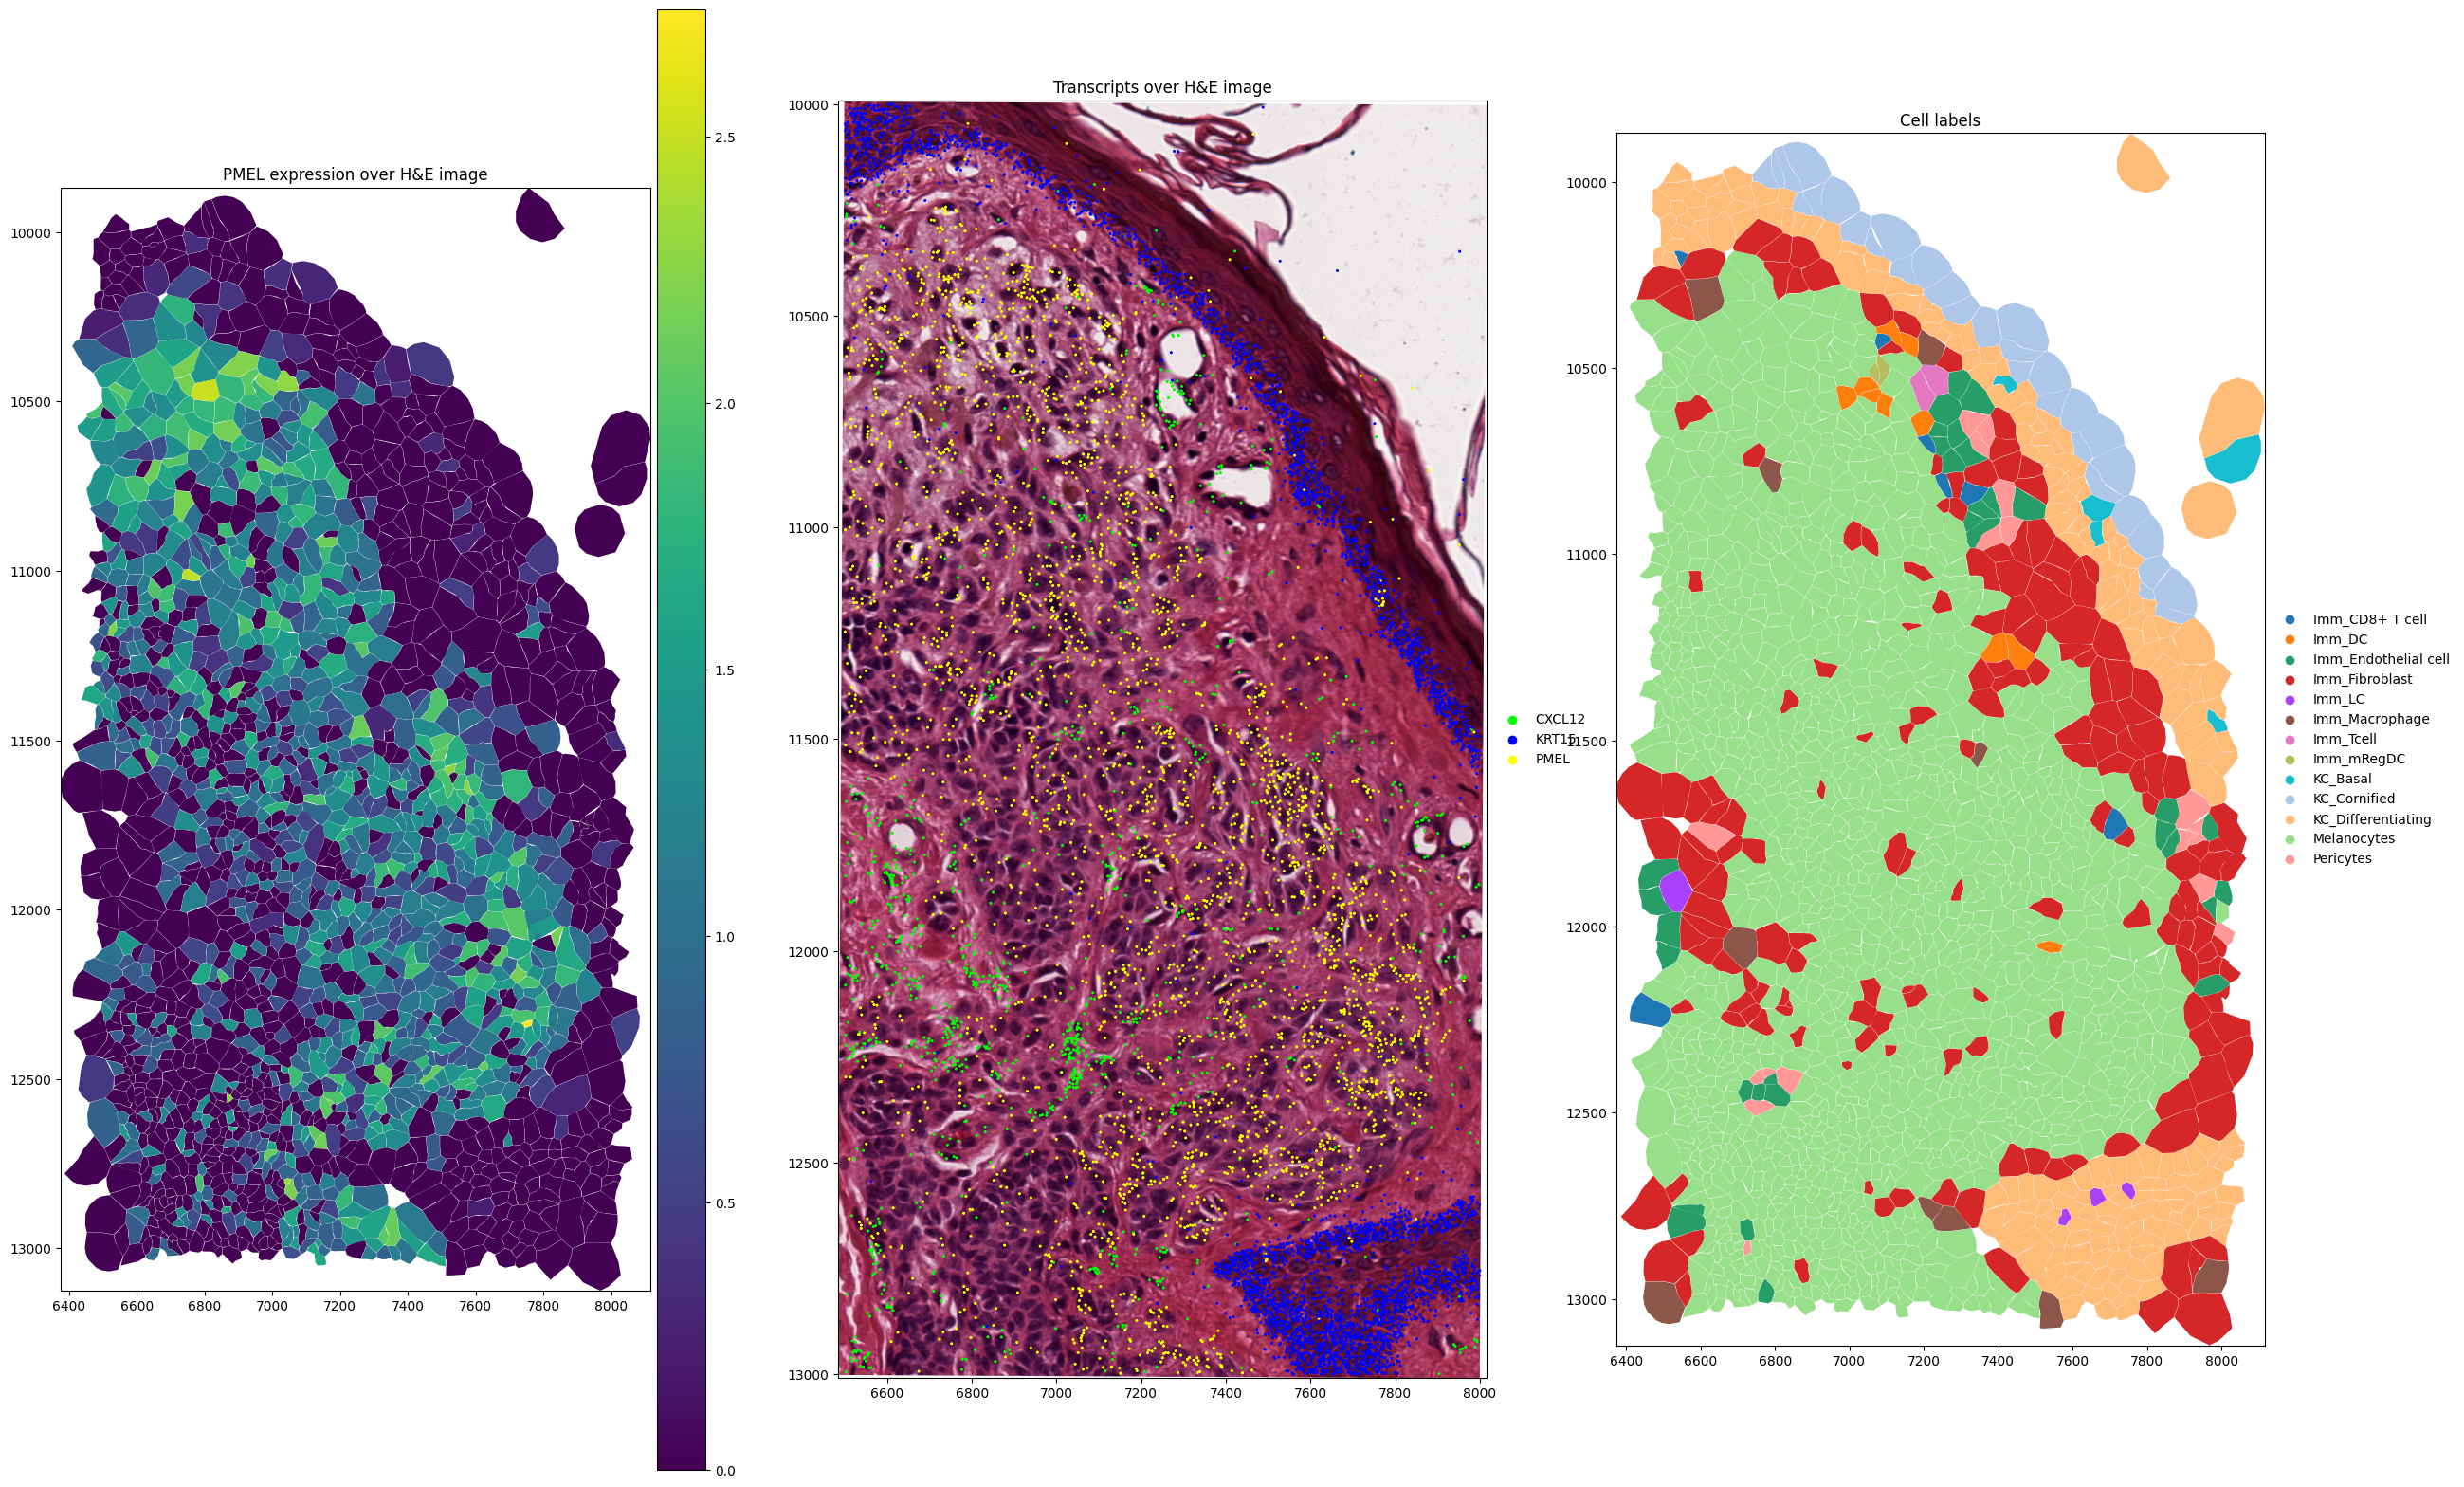

In [13]:
gene_name1 = "PMEL"
gene_name2 = "KRT15"
gene_name3 = "CXCL12"

axes = plt.subplots(1, 3, figsize=(30, 20))[1].flatten()

sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

crop0(sdata).pl.render_shapes(
    "cell_boundaries",
    color=gene_name1,
).pl.show(title=f"{gene_name1} expression over H&E image", coordinate_systems="global", ax=axes[0])

crop0(sdata).pl.render_images("HE").pl.render_points(
    "transcripts",
    color="feature_name",
    groups=[gene_name1, gene_name2, gene_name3],
    palette=["yellow", "blue", "lime"],
).pl.show(title=f"Transcripts over H&E image", coordinate_systems="global", ax=axes[1])

crop0(sdata).pl.render_shapes("cell_boundaries", color="cell_types", table="table").pl.show(ax=axes[2], title="Cell labels", coordinate_systems="global")